# Explainer Notebook

### PART 1: Gather Data
- Get all links in initial page
- Make dataframe with columns: [URL, Title, List references, List paragraph texts]

### PART 2:
-

In [1]:
# Options
OPTION_PERFORM_SCRAPE = False
OPTION_SAVE_FIG = False
OPTION_SHOW_PLOT = True

In [2]:
# Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
from util import wiki_util, nlp_util
from tqdm import tqdm
from ast import literal_eval
from collections import defaultdict
import networkx as nx
from netwulf.interactive import visualize
import matplotlib.pyplot as plt
import numpy as np
import community
from collections import OrderedDict
from operator import getitem
import importlib


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Static Variables
LINK_WIKI_ENGLISH = "https://en.wikipedia.org/wiki/Cold_War"
LINK_WIKI_GERMAN = "https://de.wikipedia.org/wiki/Kalter_Krieg"
EVENT_FILTER = ["conflicts", "conflict", "events", "event", "wars", "war", "coups", "coup",
                "crises", "crisis", "coup d'état", "history", "warfare", "battle", "battles"
                "invasion", "invasions", "revolution", "revolutions"]
PERSON_FILTER = ["births", "deaths", "people", "leader", "leaders", "politicians", "politician",
                 "writer", "writers", "scientist", "scientists", "personnel", "family", "families",
                 "executive", "executives", "spy", "spies", "person"]

In [4]:
def get_content_soup(link_wikipedia):
    website = requests.get(link_wikipedia)
    content_soup = BeautifulSoup(website.content)
    return content_soup

def soup_get_title(wiki_content_soup):
    head = wiki_content_soup.find("h1", {"id": "firstHeading"})
    return head.text

def soup_get_reference_links(wiki_content_soup, language="en"):
    p_elements = wiki_content_soup.find_all("p")
    links = [a['href'] for p in p_elements for a in p.find_all("a", href=True)]
    links = [wiki_util.hyperlink_cleanup(link, language) for link in links]
    links = [link for link in links if link != False]
    return links

def soup_get_category_texts(wiki_content_soup, language="en"):
    html_div = wiki_content_soup.find("div", {"id": "mw-normal-catlinks"})
    links_without_categories = html_div.find("ul")
    links = links_without_categories.find_all("a")
    link_texts = [a.text for a in links]
    return link_texts

def soup_get_paragraph_texts(wiki_content_soup):
    p_elements = wiki_content_soup.find_all("p")
    paragraph_texts = [p.text for p in p_elements]
    return paragraph_texts

def get_all_reference_links(link_wikipedia, language):
    website = requests.get(link_wikipedia)
    content_soup = BeautifulSoup(website.content)
    p_elements = content_soup.find_all("p")
    links = [a['href'] for p in p_elements for a in p.find_all("a", href=True)]
    links = [wiki_util.hyperlink_cleanup(link, language) for link in links]
    links = [link for link in links if link != False]
    return links


In [5]:
# Scrape English version
if OPTION_PERFORM_SCRAPE:
    links_to_scan = get_all_reference_links(LINK_WIKI_ENGLISH, "en") + [LINK_WIKI_ENGLISH]
    links_to_scan = sorted(list(set(links_to_scan)))
    data = []
    for url in tqdm(links_to_scan):
        soup = get_content_soup(url)
        title = soup_get_title(soup)
        list_references = soup_get_reference_links(soup, language="en")
        list_paragraph_texts = soup_get_paragraph_texts(soup)
        list_category_texts = soup_get_category_texts(soup)
        data.append([url, title, list_references, list_paragraph_texts, list_category_texts])


In [6]:
# Save English version
if OPTION_PERFORM_SCRAPE:
    COLUMN_NAMES = ['URL', 'TITLE', 'LIST_REFERENCES', 'LIST_PARAGRAPH_TEXTS', "CATEGORIES"]
    df_wikipedia_english = pd.DataFrame(data, columns=COLUMN_NAMES)
    df_wikipedia_english = df_wikipedia_english.set_index('URL')
    df_wikipedia_english.to_csv('./data/wiki_english.csv')

In [7]:
# Scrape German Version
if OPTION_PERFORM_SCRAPE:
    links_to_scan = get_all_reference_links(LINK_WIKI_GERMAN, language="de") + [LINK_WIKI_GERMAN]
    links_to_scan = sorted(list(set(links_to_scan)))
    data = []
    for url in tqdm(links_to_scan):
        soup = get_content_soup(url)
        title = soup_get_title(soup)
        list_references = soup_get_reference_links(soup, language="de")
        list_paragraph_texts = soup_get_paragraph_texts(soup)
        list_category_texts = soup_get_category_texts(soup)
        data.append([url, title, list_references, list_paragraph_texts, list_category_texts])


In [8]:
# Save German Version
if OPTION_PERFORM_SCRAPE:
    COLUMN_NAMES = ['URL', 'TITLE', 'LIST_REFERENCES', 'LIST_PARAGRAPH_TEXTS', "CATEGORIES"]
    df_wikipedia_german = pd.DataFrame(data, columns=COLUMN_NAMES)
    df_wikipedia_german = df_wikipedia_german.set_index('URL')
    df_wikipedia_german.to_csv('./data/wiki_german.csv')

### Load data

In [9]:
#df_wikipedia_english = pd.read_csv('./data/wiki_english.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval})

#df_wikipedia_english['TYPE'] = df_wikipedia_english_fromCSV.apply(lambda x: wiki_util.get_category(x['CATEGORIES'], EVENT_FILTER, PERSON_FILTER), axis=1)

df_wikipedia_english = pd.read_csv('./data/wiki_english_with_tokens.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval, "TOKENS": literal_eval, "UNIQUE_TOKENS": literal_eval})

#df_wikipedia_german_fromCSV = pd.read_csv('./data/wiki_german.csv', index_col='URL', converters={'LIST_REFERENCES': literal_eval, 'LIST_PARAGRAPH_TEXTS': literal_eval, "CATEGORIES": literal_eval})


#df_wikipedia_german_fromCSV['TYPE'] = df_wikipedia_german_fromCSV.apply(lambda x: wiki_util.get_category(x['CATEGORIES'], EVENT_FILTER, PERSON_FILTER), axis=1)

# Virker til en vis grænse, nogle småting der ikke bliver fanget ordenligt. None filteret virker bedst.

In [10]:
def get_graph_stats(graph):
    def format_print(str1, str2):
        print("{:>15}".format(str1), "{:>15}".format(str2))

    if graph.is_directed():
        in_degrees = [x[1] for x in graph.in_degree]
        out_degrees = [x[1] for x in graph.out_degree]
    else:
        degrees = [x[1] for x in graph.degree]

    format_print('Statistic', 'Value')
    format_print('N Nodes', len(graph.nodes))
    format_print('N Edges', len(graph.edges))
    if graph.is_directed():
        format_print('Max in_degree', max(in_degrees))
        format_print('Min in_degree', min(in_degrees))
        format_print('Max out_degree', max(out_degrees))
        format_print('Min out_degree', min(out_degrees))
        format_print('Mean in_degree', "{: 2.2f}".format(np.mean(in_degrees)))
        format_print('Mean out_degree', "{: 2.2f}".format(np.mean(out_degrees)))
    else:
        format_print('Max degree', max(degrees))
        format_print('Min degree', min(degrees))
        format_print('Mean degree', "{: 2.2f}".format(np.mean(degrees)))

def produce_communities(graph, resolution=0.3):
    list_communities = nx.community.louvain_communities(graph, seed=1, resolution=resolution)

    list_communities.sort(key=len, reverse=True)
    #print(len(list_communities))

    nice_colors = ['#0fdbff', '#0fdbff', '#ff0fb3', '#5e3582', '#ffe70f', '#1e9648', '#1e6296', '#4a1e96', '#961e6a', '#51888c']

    DEFAULT_COLOR = '#8c8c8c'
    partition_colors = defaultdict(lambda: DEFAULT_COLOR)

    for i in range(len(nice_colors)):
        partition_colors[i] = nice_colors[i]

    for node in graph.nodes:
        for i in range(len(list_communities)):
            if node in list_communities[i]:
                graph.nodes[node]['color'] = partition_colors[i]
                graph.nodes[node]['community'] = i

    return graph, len(list_communities)


In [11]:
en_edge_list = wiki_util.get_edge_list(df_wikipedia_english)
en_edge_list_directed = wiki_util.get_edge_list(df_wikipedia_english, directed=True)

graph_en_directed = nx.DiGraph()
graph_en_directed.add_weighted_edges_from(en_edge_list_directed)
graph_en_directed = wiki_util.generate_graph_with_node_attributes(graph_en_directed, df_wikipedia_english)

100%|██████████| 859/859 [00:00<00:00, 3291.18it/s]


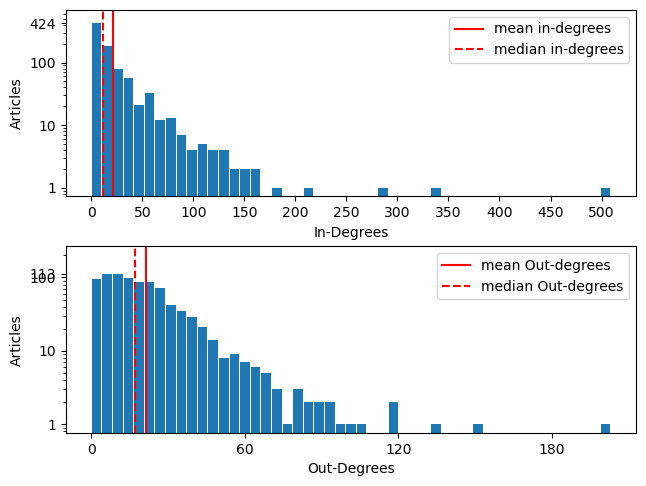

In [12]:
G = graph_en_directed

if OPTION_SHOW_PLOT:
    in_degrees = [x[1] for x in G.in_degree]
    out_degrees = [x[1] for x in G.out_degree]
    bins = np.linspace(min(in_degrees), max(in_degrees), 50)

    mean = np.mean(in_degrees)
    median = np.median(in_degrees)

    hist, edges = np.histogram(in_degrees, bins=bins)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1] - bins[0]
    fig, axs = plt.subplots(2)
    axs[0].bar(x, hist, width=width*0.9)

    axs[0].set_xlabel('In-Degrees')
    axs[0].set_ylabel('Articles')
    axs[0].set_yscale('log')
    axs[0].set_xticks(range(0, 501, 50))
    axs[0].set_yticks([10**0, 10**1, 10**2, max(hist)], labels=[10**0, 10**1, 10**2, max(hist)])
    axs[0].axline((mean, 0), (mean, max(in_degrees)), color='red', label='mean in-degrees')
    axs[0].axline((median, 0), (median, max(in_degrees)), linestyle='--', color='red', label='median in-degrees')
    axs[0].legend()

    bins = np.linspace(min(out_degrees), max(out_degrees), 50)

    mean = np.mean(out_degrees)
    median = np.median(out_degrees)

    hist, edges = np.histogram(out_degrees, bins=bins)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1] - bins[0]
    axs[1].bar(x, hist, width=width*0.9)

    axs[1].set_xlabel('Out-Degrees')
    axs[1].set_ylabel('Articles')
    axs[1].set_yscale('log')
    axs[1].set_xticks(range(0, int(max(list(bins))), 60))
    axs[1].set_yticks([10**0, 10**1, 10**2, max(hist)], labels=[10**0, 10**1, 10**2, max(hist)])
    axs[1].axline((mean, 0), (mean, max(out_degrees)), color='red', label='mean Out-degrees')
    axs[1].axline((median, 0), (median, max(out_degrees)), linestyle='--', color='red', label='median Out-degrees')
    axs[1].legend()
    fig.tight_layout(pad=0.5)
    plt.show()
    if OPTION_SAVE_FIG:
        fig.savefig("./images/degree_distributions.png")

# TK IDF

In [13]:
importlib.reload(nlp_util)
importlib.reload(wiki_util)
print()

def get_attributes_for_community(graph, community, attribute):
    list_attribute = []
    for (n, d) in graph.nodes(data=True):
        if d['community'] == community:
            list_attribute.append(d[attribute])

    return list_attribute

def get_attributes_for_graph(graph, attribute):
    list_attribute = []
    for (n, d) in graph.nodes(data=True):
        list_attribute.append(d[attribute])

    return list_attribute

class CSSGraph:
    def __init__(self, directed=False):
        self.n_communities = 0
        self.directed = directed
        self.visualize_config = None
        self.graph_corpus = None
        self.community_corpus = [] #Maybe not needed

        self.tf_idf_df = None

        self.community_top_10_tf = {}
        self.community_top_10_tf_idf = {}
        self.community_top_3_nodes = {}

        self.vectorizer = None
        self.tf_idf_matrix = None

        if directed:
            self.graph = nx.DiGraph()
        else:
            self.graph = nx.Graph()

    def add_weighted_edges_from(self, edge_list):
        self.graph.add_weighted_edges_from(edge_list)

    def populate_node_attributes(self, df):
        self.graph = wiki_util.generate_graph_with_node_attributes(self.graph, df)

    def print_graph_stats(self):
        get_graph_stats(self.graph)

    def make_subgraph_with_attribute_values(self, attribute, values):
        self.graph = wiki_util.get_subgraph(self.graph, attribute=attribute, values=values)

    def filter_nodes_by_degree(self, d_min, d_max):
        if self.directed:
            self.graph = wiki_util.threshold_node_degree_directed(self.graph, min = d_min, max= d_max)
        else:
            self.graph = wiki_util.threshold_node_degree_undirected(self.graph, min=d_min, max=d_max)

    def embed_communities(self, resolution=1):
        self.graph, self.n_communities = produce_communities(self.graph, resolution)
        self.embed_graph_corpus()
        self.embed_community_corpus()

    def visualize(self, graph_saving=False):
        if not graph_saving:
            visualize(self.graph)
        elif self.visualize_config is None:
            _, self.visualize_config = visualize(self.graph)
        else:
            visualize(self.graph, config=self.visualize_config)

    def embed_graph_corpus(self):
        if self.graph_corpus is None:
            self.graph_corpus = get_attributes_for_graph(self.graph, 'FLAT_TEXT')

    def embed_tf_idf(self, max_df=1, min_df=1, max_features=100):
        self.tf_idf_matrix, self.vectorizer = nlp_util.tf_idf_sklearn(self.community_corpus, max_df=max_df, min_df=min_df, max_features=max_features)
        self.tf_idf_df = pd.DataFrame(graph_en.tf_idf_matrix.toarray(), columns=graph_en.vectorizer.get_feature_names_out())

    def get_top_terms(self, community=None):
        if community is None:
            return [list(self.tf_idf_df.iloc[c].sort_values(ascending=False)[:10].index) for c in range(self.n_communities)]
        else:
            return list(self.tf_idf_df.iloc[community].sort_values(ascending=False)[:10].index)

    def get_nodes_in_community(self, community):
        return [node for node, c in self.graph.nodes(data='community') if c == community]

    def get_top_nodes(self, community=0, n_max = 3):
        nodes_in_community = self.get_nodes_in_community(community)
        degrees = [(node,val) for (node, val) in self.graph.degree() if node in nodes_in_community]
        sorted_degree= sorted(degrees, key=lambda x: x[1], reverse=True)[:n_max]
        return [node for node, val in sorted_degree]

    # Maybe not needed
    def embed_community_corpus(self):
        if len(self.community_corpus) != self.n_communities:
            for n in range(self.n_communities):
                self.community_corpus.append(' '.join(get_attributes_for_community(self.graph, n, 'FLAT_TEXT')))


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/philiphelsted/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
# Create Graph
graph_en = CSSGraph()
graph_en.add_weighted_edges_from(en_edge_list)
graph_en.populate_node_attributes(df_wikipedia_english)

# Filter Graph
graph_en.make_subgraph_with_attribute_values('TYPE', ['person'])
graph_en.filter_nodes_by_degree(d_min=10, d_max=50)

# Community Analysis
graph_en.embed_communities(resolution=1)
graph_en.embed_tf_idf(max_df=0.99, min_df=0, max_features=100)

# Various data
graph_en.print_graph_stats()
print("Number of communities:", graph_en.n_communities)
print("Top 10 terms in community 0")
print(graph_en.get_top_terms(0))
print("Top 3 nodes in community 0")
print(graph_en.get_top_nodes(0))


      Statistic           Value
        N Nodes              72
        N Edges             522
     Max degree              38
     Min degree               6
    Mean degree           14.50
Number of communities: 5
Top 10 terms in community 0
['kennan', 'macarthur', 'eisenhower', 'reagan', 'bush', 'reza', 'hoover', 'wilson', 'carter', 'macmillan']
Top 3 nodes in community 0
['https://en.wikipedia.org/wiki/Richard_Nixon', 'https://en.wikipedia.org/wiki/Dwight_D._Eisenhower', 'https://en.wikipedia.org/wiki/Harry_S._Truman']


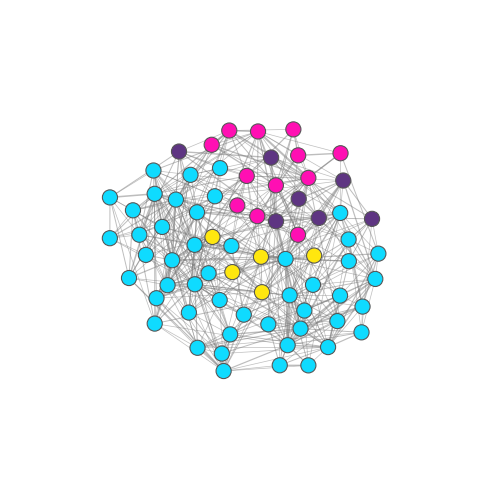

In [16]:
graph_en.visualize(graph_saving=True)